In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

# Part ③ - Maintenance

## Table of contents
- <a href='#C0'>0. Importing libraries and dataframe</a>
- <a href='#C1'>1. Maintenance</a>

# <a name='C0'>0. Importing libraries and dataframe</a>

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from math import pi
from random import randrange
import time

import matplotlib.image as mpimg
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import os
if not os.path.exists('images'):
    os.mkdir('images')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, adjusted_rand_score,\
    davies_bouldin_score
from sklearn import decomposition
from sklearn import manifold
from sklearn.manifold import TSNE
import umap
from datetime import datetime, timedelta
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import cluster

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("white")

In [3]:
df = pd.read_csv('df_rfm.csv')

In [13]:
df.head()

,monetary,frequency,recency,perc_credit,mean_review_score,mean_nb_of_items,product_weight_g
0,3.691376,0.693147,302,0.0,5.0,0.693147,5.525453
1,5.399429,1.098612,96,0.0,5.0,0.693147,6.883463
2,7.026427,0.693147,215,1.0,4.0,0.693147,9.655090
3,3.921775,0.693147,17,0.0,5.0,0.693147,7.244942
4,4.756689,0.693147,192,1.0,5.0,0.693147,6.311735


In [10]:
df.recency.describe()

count    10000.000000
mean       237.473900
std        153.685649
min          0.000000
25%        112.000000
50%        218.000000
75%        349.000000
max        694.000000
Name: recency, dtype: float64

# <a name='C1'>1. Maintenance</a>

In [128]:
def stability(df, model, nb_iter=10):

    date_min = 0
    date_init = 360
    date_max = 500

    mask1 = (df.recency < date_init)
    X_init = df[mask1]
    model.fit(X_init)
    clusters_init = model.labels_

    ARI_results = pd.DataFrame()
    index = -1
    date_lim = date_init

    while date_lim < date_max:
        index += 1
        mask2 = (df.recency < date_lim)
        X_trunc = df[mask2]

        ARI_scores = []
        for i in range(nb_iter):
            model.fit(X_trunc)
            list_init = X_init.index
            mask = X_trunc.index.isin(list_init)
            clusters_new = model.labels_[mask]

            ARI_score = adjusted_rand_score(clusters_init, clusters_new)
            ARI_scores.append(ARI_score)

            ARI_results.loc[index, 'period'] = date_lim
            ARI_results.loc[index, 'ARI_score_mean'] =  np.mean(ARI_scores)

        date_lim += 15

    return ARI_results

In [129]:
stability1 = stability(df,
                       model = KMeans(n_clusters=7,
                                      init='k-means++',
                                      random_state=1)
                       )

In [130]:
stability1

,period,ARI_score_mean
0,360.0,1.000000
1,375.0,0.989733
2,390.0,0.899704
3,405.0,0.873356
4,420.0,0.654486
5,435.0,0.648759
6,450.0,0.644466
7,465.0,0.632647
8,480.0,0.622457
9,495.0,0.611699


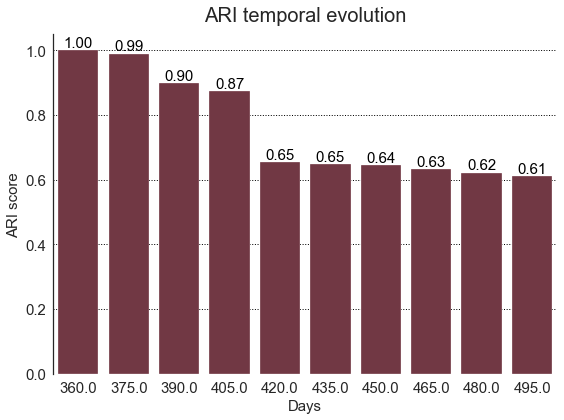

In [131]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x=stability1.period,
                   y=stability1.ARI_score_mean, 
                   color='#7B2E3E')

container = ax.containers[0]
df_len = len(stability1.period)
ax.bar_label(container,
             labels=[f'{x:.2f}' for x in container.datavalues],
             label_type='edge',
             size=15,
             color='black'
             )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(axis='y', color='black', ls=':')

plt.title('ARI temporal evolution', fontsize=20, y=1.02)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Days', fontsize=15)
plt.ylabel('ARI score', fontsize=15)
plt.tight_layout()
plt.savefig('ARI_maintenance.png', transparent=True, bbox_inches='tight')
plt.show()